In [1]:
# V√©rification du json (configuration des seuils de classes)
import json
from pprint import pprint

# Charger le fichier pour v√©rification
with open("/workspace/configs/seuils_par_classe.json", "r") as f:
    data = json.load(f)

# V√©rifie la pr√©sence de "class_name" dans chaque dictionnaire
print("üîç V√©rification du champ 'class_name' dans le JSON :\n")
for cls, vals in data.items():
    has_field = "class_name" in vals
    print(f"{cls:<6} ‚Üí {'‚úÖ pr√©sent' if has_field else '‚ùå absent'}")

# (optionnel) afficher un exemple complet
print("\nExemple de seuils pour la premi√®re classe :")
first_cls = next(iter(data))
pprint(data[first_cls])


üîç V√©rification du champ 'class_name' dans le JSON :

ADI    ‚Üí ‚úÖ pr√©sent
BACK   ‚Üí ‚úÖ pr√©sent
DEB    ‚Üí ‚úÖ pr√©sent
LYM    ‚Üí ‚úÖ pr√©sent
MUC    ‚Üí ‚úÖ pr√©sent
MUS    ‚Üí ‚úÖ pr√©sent
NORM   ‚Üí ‚úÖ pr√©sent
STR    ‚Üí ‚úÖ pr√©sent
TUM    ‚Üí ‚úÖ pr√©sent

Exemple de seuils pour la premi√®re classe :
{'class_name': 'ADI',
 'entropy_min': 4.066034075179459,
 'jpeg_blockiness_max': 0.8511592745516547,
 'lap_var_min': 250.78582164608704,
 'sat_ratio_max': 0.008104472257653057,
 'tenengrad_min': 8548.572265625,
 'tissue_frac_min': 0.9120196906887754,
 'white_ratio_max': 0.14578782684948885}


In [2]:
# üß´ Test du DataGenerator - version propre et √©chantillonn√©e
# Ce notebook permet de valider le bon fonctionnement du `HistoDataset` :
# - D√©tection automatique du dossier de donn√©es
# - Chargement train / val avec √©chantillonnage r√©duit
# - Calibration des m√©triques qualit√©
# - Visualisation rapide
# - Test DataLoader sur GPU / CPU

import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from p9dg.histo_dataset import HistoDataset

# ## 1Ô∏è‚É£ Configuration de base (auto-d√©tection du dossier data)
CANDIDATES = ["/workspace/data", "/data", "./data"]
ROOT_DATA = next((d for d in CANDIDATES if os.path.isdir(os.path.join(d, "NCT-CRC-HE-100K"))), None)
if ROOT_DATA is None:
    raise FileNotFoundError("Impossible de trouver le dossier de dataset (NCT-CRC-HE-100K). V√©rifie le montage Docker.")
else:
    print(f"‚úÖ Dataset trouv√© dans : {ROOT_DATA}")

IMG_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8

print(f"Device utilis√© : {DEVICE}")

‚úÖ Dataset trouv√© dans : /workspace/data
Device utilis√© : cuda


In [3]:
# ## 2Ô∏è‚É£ Chargement du dataset avec √©chantillonnage
MAX_PER_CLASS_TRAIN = 200
MAX_PER_CLASS_VAL = 50

print("\nüîπ Chargement du dataset TRAIN (√©chantillonn√©)...")
ds_train = HistoDataset(
    root_data=ROOT_DATA,
    split="train",
    output_size=IMG_SIZE,
    thresholds_json_path="seuils_par_classe.json",
    vahadane_enable=True,
    vahadane_device=DEVICE,
)

print("\nüîπ Chargement du dataset VAL (√©chantillonn√©)...")
ds_val = HistoDataset(
    root_data=ROOT_DATA,
    split="val",
    output_size=IMG_SIZE,
    thresholds_json_path="seuils_par_classe.json",
    vahadane_enable=False,
)

def subsample_dataset(ds, max_per_class=200):
    """Retourne un sous-ensemble √©quilibr√© sans d√©passer max_per_class par classe."""
    selected_indices = []
    for ci in range(len(ds.paths_by_class)):
        # indices correspondants √† la classe ci dans _epoch_indices
        class_indices = [k for k, (c, _) in enumerate(ds._epoch_indices) if c == ci]
        selected_indices += class_indices[:max_per_class]
    return Subset(ds, selected_indices)


ds_train_small = subsample_dataset(ds_train, MAX_PER_CLASS_TRAIN)
ds_val_small = subsample_dataset(ds_val, MAX_PER_CLASS_VAL)

print(f"\nTaille finale train: {len(ds_train_small)}  |  val: {len(ds_val_small)}")


üîπ Chargement du dataset TRAIN (√©chantillonn√©)...
üé® R√©f√©rence Vahadane fix√©e : TUM-RQEVGAED.tif
üé® R√©f√©rence Vahadane auto: TUM-RQEVGAED.tif
‚úÖ Seuils par classe charg√©s depuis : /workspace/configs/seuils_par_classe.json

üîπ Chargement du dataset VAL (√©chantillonn√©)...
‚úÖ Seuils par classe charg√©s depuis : /workspace/configs/seuils_par_classe.json

Taille finale train: 1800  |  val: 450


In [4]:
print("Normalisation activ√©e :", ds_train.stain.enable)
print("torch_staintools charg√© :", ds_train.stain._normalizer is not None)
print("R√©f√©rence OK :", ds_train.stain._ok)
print("Image de r√©f√©rence :", ds_train.stain._target)


Normalisation activ√©e : True
torch_staintools charg√© : True
R√©f√©rence OK : True
Image de r√©f√©rence : /workspace/data/NCT-CRC-HE-100K/TUM/TUM-RQEVGAED.tif


In [5]:
# ## 3Ô∏è‚É£ Calibration des m√©triques qualit√©
print("\nCalibration blockiness par classe (moyenne ¬± √©cart-type):")
for cls, stats in ds_train.block_stats.items():
    mu_s, sd_s = stats['spatial']
    mu_d, sd_d = stats['dct']
    print(f" - {cls:<10} spatial={mu_s:.2f}¬±{sd_s:.2f} | dct={mu_d:.2f}¬±{sd_d:.2f}")


Calibration blockiness par classe (moyenne ¬± √©cart-type):
 - ADI        spatial=0.24¬±0.42 | dct=0.99¬±0.01
 - BACK       spatial=0.23¬±0.47 | dct=1.00¬±0.01
 - DEB        spatial=0.12¬±0.22 | dct=0.98¬±0.01
 - LYM        spatial=0.13¬±0.20 | dct=0.97¬±0.01
 - MUC        spatial=0.12¬±0.25 | dct=0.98¬±0.01
 - MUS        spatial=0.13¬±0.24 | dct=0.98¬±0.01
 - NORM       spatial=0.09¬±0.15 | dct=0.98¬±0.01
 - STR        spatial=0.11¬±0.22 | dct=0.98¬±0.01
 - TUM        spatial=0.11¬±0.18 | dct=0.98¬±0.01


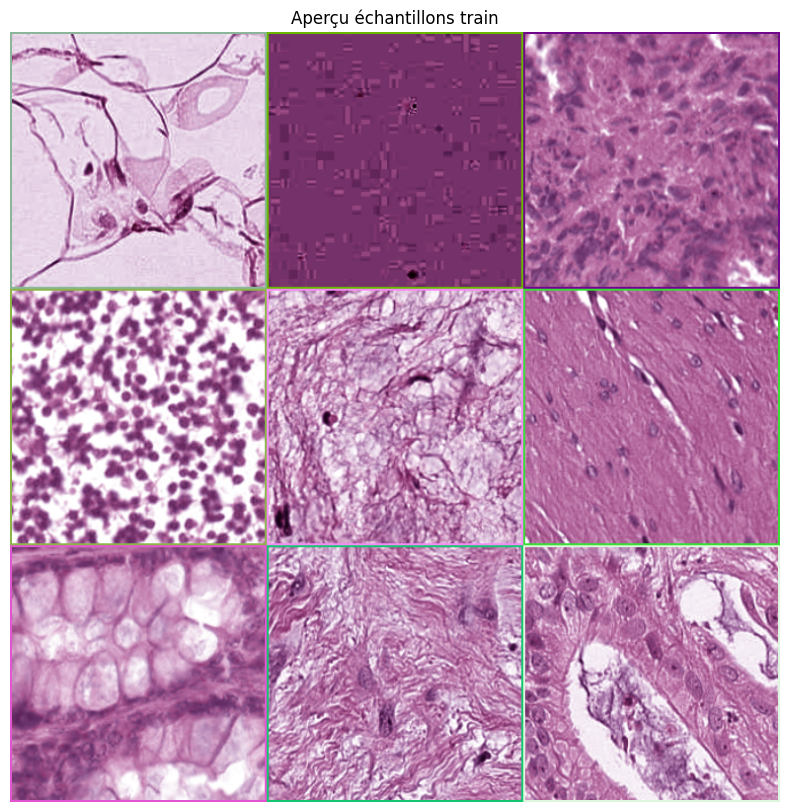

In [6]:
# ## 4Ô∏è‚É£ Visualisation rapide
grid = ds_train.vis(n=16)
plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.axis('off')
plt.title("Aper√ßu √©chantillons train")
plt.show()

In [7]:
# ## 5Ô∏è‚É£ DataLoader et mini-test GPU
loader = DataLoader(ds_train_small, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print("\n‚è±Ô∏è Test du chargement d'un batch...")
for i, (x, y, path) in enumerate(loader):
    print(f"Batch {i}: images={x.shape}, labels={y.shape}")
    x = x.to(DEVICE)
    break
print("\n‚úÖ Passage sur device r√©ussi !")


‚è±Ô∏è Test du chargement d'un batch...
Batch 0: images=torch.Size([8, 3, 256, 256]), labels=torch.Size([8])

‚úÖ Passage sur device r√©ussi !


In [8]:
# ## 6Ô∏è‚É£ V√©rifications finales
print("\nNombre d'images par classe (train):")
for cls, n in ds_train.class_counts().items():
    print(f" - {cls:<10}: {n}")

x0, y0, path0 = ds_train[0]
print(f"\nExemple -> tensor={tuple(x0.shape)}, classe={y0}, chemin={path0}")

print("\n‚úÖ Test du DataGenerator termin√© avec succ√®s.")


Nombre d'images par classe (train):
 - ADI       : 10407
 - BACK      : 10566
 - DEB       : 11512
 - LYM       : 11557
 - MUC       : 8896
 - MUS       : 13536
 - NORM      : 8763
 - STR       : 10446
 - TUM       : 14317

Exemple -> tensor=(3, 256, 256), classe=1, chemin=/workspace/data/NCT-CRC-HE-100K/BACK/BACK-CHMRSFAK.tif

‚úÖ Test du DataGenerator termin√© avec succ√®s.


## 7Ô∏è‚É£ Benchmark de performance du DataLoader (lecture + normalisation)

In [10]:
import time
import numpy as np
from tqdm import tqdm

def benchmark_dataloader(ds, batch_size=8, num_workers=2, n_batches=20, device=DEVICE):
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    times = []
    start_global = time.time()

    for i, (x, y, path) in enumerate(tqdm(loader, total=n_batches, desc="‚è±Ô∏è Lecture des batches")):
        t0 = time.time()
        x = x.to(device, non_blocking=True)
        torch.cuda.synchronize() if device.startswith("cuda") else None
        t_batch = time.time() - t0
        times.append(t_batch)
        if i + 1 >= n_batches:
            break

    total_time = time.time() - start_global
    mean_batch = np.mean(times)
    imgs_per_sec = (batch_size * n_batches) / total_time

    print(f"\nTemps total: {total_time:.2f}s pour {n_batches} batches de {batch_size}")
    print(f"‚è±Ô∏è Temps moyen par batch: {mean_batch*1000:.1f} ms")
    print(f"‚ö° D√©bit moyen: {imgs_per_sec:.1f} images/s\n")

# Ex√©cution sur un sous-ensemble (pour √©viter la surcharge)
benchmark_dataloader(ds_train_small, batch_size=BATCH_SIZE, num_workers=0)

# num_workers>0 d√©clenche une erreur qui est un bug d‚Äôinteraction entre PyTorch multiprocessing
# et Jupyter/IPython (li√© √† la gestion des sockets de communication entre workers)

‚è±Ô∏è Lecture des batches:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 19/20 [00:58<00:03,  3.09s/it]


Temps total: 58.66s pour 20 batches de 8
‚è±Ô∏è Temps moyen par batch: 0.8 ms
‚ö° D√©bit moyen: 2.7 images/s



# Validations quantitatives

In [11]:
# üîç 1Ô∏è‚É£ Sanity check sur les √©tiquettes
for i in range(5):
    _, y, path = ds_train[i]
    print(f"{i:02d} -> classe idx={y}, nom={ds_train.idx_to_class[int(y)]}, path={os.path.basename(path)}")


00 -> classe idx=1, nom=BACK, path=BACK-CHMRSFAK.tif
01 -> classe idx=4, nom=MUC, path=MUC-IENASFMH.tif
02 -> classe idx=3, nom=LYM, path=LYM-MSGDQPHY.tif
03 -> classe idx=7, nom=STR, path=STR-MAVGGNIK.tif
04 -> classe idx=7, nom=STR, path=STR-WKANEAWK.tif


In [12]:
# %% [markdown]
# ## üîç V√©rification du mapping explicite des classes

from p9dg.utils.class_mappings import make_idx_mappings

# G√©n√©ration des mappings √† partir du dataset
idx_to_name, idx_to_color, name_to_color = make_idx_mappings(ds_train.class_to_idx)

print("Mapping index -> nom explicite :")
for i, name in idx_to_name.items():
    print(f"{i:2d} -> {name}")

print("\Couleur associ√©e :")
for i, color in idx_to_color.items():
    print(f"{i:2d} -> {color}")


Mapping index -> nom explicite :
 0 -> Tissu adipeux
 1 -> Arri√®re-plan (fond sans tissu)
 2 -> D√©bris cellulaires / n√©crose
 3 -> Lymphocytes (infiltrat immunitaire)
 4 -> Mucus (s√©cr√©tions)
 5 -> Tissu musculaire lisse
 6 -> Muqueuse colique normale
 7 -> Stroma associ√© au cancer
 8 -> √âpith√©lium ad√©nocarcinomateux (tumeur)
\Couleur associ√©e :
 0 -> #F2CEEE
 1 -> #D859D0
 2 -> #A50026
 3 -> #4575B4
 4 -> #74ADD1
 5 -> #D73027
 6 -> #D4DF38
 7 -> #762A83
 8 -> #000000


üí° Rappel : ce que fait l'utilitaire make_idx_mappings

| Variable        | Type | Contenu                                                              |
| --------------- | ---- | -------------------------------------------------------------------- |
| `idx_to_name`   | dict | ex. `{0: 'Tissu adipeux', 1: 'Arri√®re-plan (fond sans tissu)', ...}` |
| `idx_to_color`  | dict | ex. `{0: '#F2CEEE', 1: '#D859D0', ...}`                              |
| `name_to_color` | dict | ex. `{'ADI': '#F2CEEE', 'BACK': '#D859D0', ...}`                     |

üëâ c‚Äôest donc name_to_color qui correspond √† class_colors global.


Analyse des batches:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 19/20 [00:57<00:03,  3.03s/it]


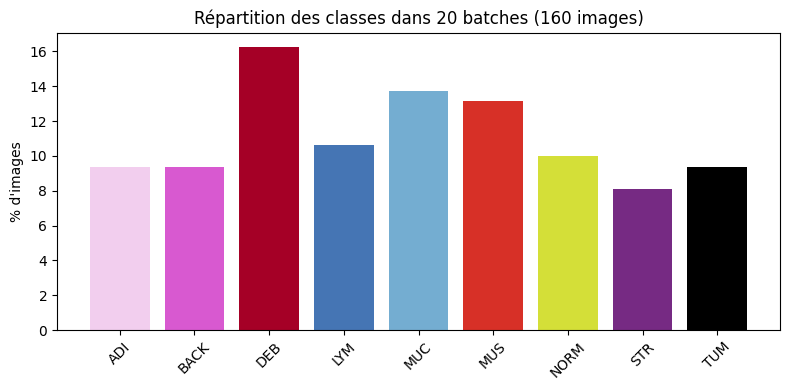

ADI    ‚Üí   9.4%
BACK   ‚Üí   9.4%
DEB    ‚Üí  16.2%
LYM    ‚Üí  10.6%
MUC    ‚Üí  13.8%
MUS    ‚Üí  13.1%
NORM   ‚Üí  10.0%
STR    ‚Üí   8.1%
TUM    ‚Üí   9.4%


In [13]:
# V√©rification de l'√©quilibrage des clases
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# --- Param√®tres du test ---
N_BATCHES = 20  # nombre de batches √† examiner
BATCH_SIZE = 8  # coh√©rent avec ton DataLoader
NUM_WORKERS = 0  # √©vite le multiprocessing sous Jupyter

loader = torch.utils.data.DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

# --- Comptage des classes sur un √©chantillon ---
counts = Counter()
for i, (_, y, _) in enumerate(tqdm(loader, total=N_BATCHES, desc="Analyse des batches")):
    y = y.cpu().numpy()
    counts.update(y)
    if i >= N_BATCHES - 1:
        break

# --- Normalisation et affichage ---
labels = [ds_train.idx_to_class[i] for i in sorted(counts.keys())]
values = [counts[i] for i in sorted(counts.keys())]
total = sum(values)
proportions = np.array(values) / total * 100

# R√©cup√©ration des mappings depuis ton utilitaire
from p9dg.utils.class_mappings import make_idx_mappings

idx_to_name, idx_to_color, name_to_color = make_idx_mappings(ds_train.class_to_idx)

# Reconstruit un dictionnaire avec les cl√©s du dataset ('ADI', 'BACK', etc.)
class_colors = {short: idx_to_color[idx] for idx, short in ds_train.idx_to_class.items()}


plt.figure(figsize=(8,4))
plt.bar(labels, proportions, color=[class_colors[c] for c in labels])
plt.title(f"R√©partition des classes dans {N_BATCHES} batches ({BATCH_SIZE*N_BATCHES} images)")
plt.ylabel("% d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- R√©sum√© num√©rique ---
for cls, val in zip(labels, proportions):
    print(f"{cls:<6} ‚Üí {val:5.1f}%")


In [14]:
# üß™ 2Ô∏è‚É£ Test du mode val / test
train_paths = {os.path.basename(p) for _, _, p in [ds_train[i] for i in range(50)]}
val_paths = {os.path.basename(p) for _, _, p in [ds_val[i] for i in range(50)]}
print(f"Chevauchements train/val: {len(train_paths & val_paths)}")


Chevauchements train/val: 0


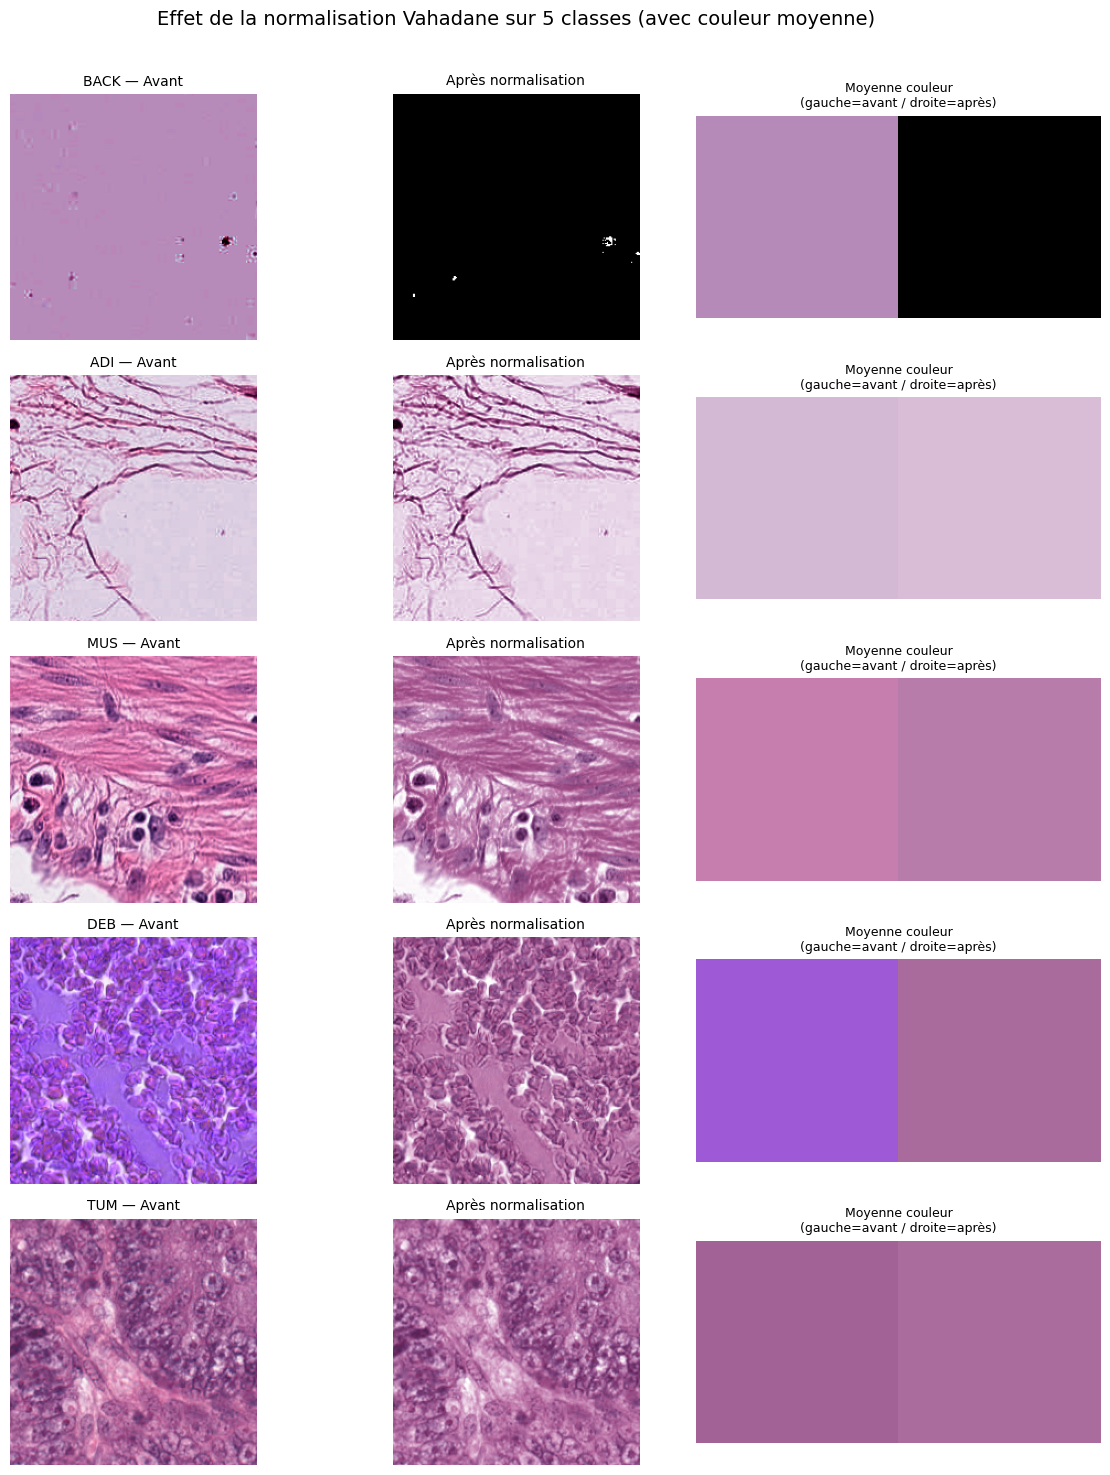

In [15]:
# üé® 3Ô∏è‚É£ V√©rification visuelle de la normalisation Vahadane (multi-classes)

# üé® 3Ô∏è‚É£ V√©rification visuelle de la normalisation Vahadane (multi-classes + moyenne couleur)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

def avg_color(img: Image.Image):
    """Retourne la couleur moyenne RGB d'une image."""
    arr = np.asarray(img).astype(np.float32) / 255.0
    return arr.mean(axis=(0, 1))

# S√©lectionner 5 classes diff√©rentes al√©atoirement
selected_classes = random.sample(list(ds_train.paths_by_class.keys()), 5)

fig, axs = plt.subplots(len(selected_classes), 3, figsize=(12, 3 * len(selected_classes)))
fig.suptitle("Effet de la normalisation Vahadane sur 5 classes (avec couleur moyenne)", fontsize=14)

for row, ci in enumerate(selected_classes):
    class_name = ds_train.idx_to_class[ci]
    sample_path = random.choice(ds_train.paths_by_class[ci])
    
    img_raw = Image.open(sample_path)
    img_norm = ds_train.stain.normalize(img_raw)
    
    # Calcul des couleurs moyennes
    c_raw = avg_color(img_raw)
    c_norm = avg_color(img_norm)
    
    # --- Colonne 1 : image brute ---
    axs[row, 0].imshow(img_raw)
    axs[row, 0].set_title(f"{class_name} ‚Äî Avant", fontsize=10)
    axs[row, 0].axis("off")
    
    # --- Colonne 2 : image normalis√©e ---
    axs[row, 1].imshow(img_norm)
    axs[row, 1].set_title("Apr√®s normalisation", fontsize=10)
    axs[row, 1].axis("off")
    
    # --- Colonne 3 : couleur moyenne avant/apr√®s (patchs juxtapos√©s) ---
    patch = np.ones((50, 100, 3))
    patch[:, :50, :] = c_raw
    patch[:, 50:, :] = c_norm
    axs[row, 2].imshow(patch)
    axs[row, 2].set_title("Moyenne couleur\n(gauche=avant / droite=apr√®s)", fontsize=9)
    axs[row, 2].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [22]:
# üì¶ 4Ô∏è‚É£ V√©rification du comportement du filtrage qualit√©
qf = ds_train.qf
thr = ds_train.class_thresholds[ds_train.idx_to_class[3]]
img = Image.open(next(iter(ds_train.paths_by_class[0])))
metrics = qf.score(img)
print(metrics)
print("‚Üí Verdict:", "OK" if qf.check(metrics, thr) else "REJET√â")


{'lap_var': 1381.604248046875, 'entropy': 5.525256792543279, 'tenengrad': 25983.638671875, 'white_ratio': 0.029057716836734693, 'sat_ratio': 0.0001992984693877551, 'block_spatial': 0.2534322738647461, 'block_dct': 0.9869521225557397, 'tissue_fract': 0.991828762755102}
‚Üí Verdict: REJET√â


In [17]:
# Teste combien d'images passent le filtre
import numpy as np
from PIL import Image
from tqdm import tqdm

results = {}
for ci, cname in ds_train.idx_to_class.items():
    thr = ds_train.class_thresholds.get(cname, {})
    ok_count, total = 0, len(ds_train.paths_by_class[ci])
    for path in np.random.choice(ds_train.paths_by_class[ci], min(50, total), replace=False):
        img = Image.open(path)
        if ds_train.qf.check(ds_train.qf.score(img), thr):
            ok_count += 1
    results[cname] = f"{ok_count}/{min(50, total)} OK"

print("\nüß™ V√©rification du filtrage qualit√© (√©chantillon de 50 images max/classe) :")
for cname, res in results.items():
    print(f"{cname:<6} ‚Üí {res}")



üß™ V√©rification du filtrage qualit√© (√©chantillon de 50 images max/classe) :
ADI    ‚Üí 50/50 OK
BACK   ‚Üí 50/50 OK
DEB    ‚Üí 17/50 OK
LYM    ‚Üí 39/50 OK
MUC    ‚Üí 10/50 OK
MUS    ‚Üí 17/50 OK
NORM   ‚Üí 20/50 OK
STR    ‚Üí 28/50 OK
TUM    ‚Üí 36/50 OK


In [18]:
print("Cl√©s disponibles dans les seuils JSON:")
print(list(ds_train.class_thresholds.keys()))


Cl√©s disponibles dans les seuils JSON:
['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
